In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Input, Conv2D, Flatten, BatchNormalization, Reshape
from keras.models import Model,Sequential
from keras.datasets import fashion_mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

In [2]:
(x_train,y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
x_train = (x_train.astype(np.float32) - 127.5)/127.5

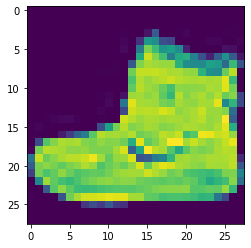

In [16]:
plt.imshow(x_train[0], cmap='Greys')

In [7]:
def create_generator():
    generator=Sequential()
    generator.add(Conv2D(64, (3,3), strides =(3,3), padding ='same', input_shape = [28,28,1]))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2D(32, (3,3), strides =(3,3), padding ='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
  
    
    generator.add(Flatten())
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=28*28, activation='tanh'))
    #generator.add(Reshape((28,28)))
    
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    return generator
g=create_generator()
g.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 10, 10, 64)        640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 32)          18464     
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 32)          128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)              

In [8]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=512,input_dim=28*28))
    #discriminator.add(Conv2D(64, (3,3), strides =(1,1), padding ='same', input_shape = [28,28,1]))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    #discriminator.add(Flatten())
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)              

In [10]:
def create_gan(discriminator, generator):
     discriminator.trainable=False
     img_shape=(28, 28, 1)
     gan_input = Input(img_shape)
     x = generator(gan_input)
     gan_output= discriminator(x)
     gan= Model(inputs=gan_input, outputs=gan_output)
     gan.compile(loss='binary_crossentropy', optimizer='adam')
     return gan

In [11]:
generator= create_generator()
discriminator= create_discriminator()
gan = create_gan(discriminator, generator)

batch_size = 128
Epochs = 300
for epcs in range(1, Epochs ):
        print("Epoch Number %d" %epcs)
        for _ in tqdm(range(batch_size)):
        #generate  random noise of shape 28*28 to initialize the generator
            noise= np.random.normal(0,1, [batch_size, 28,28,1])
       
            # Now predict the noise by feeding it to generator
            generated_images = generator.predict(noise)
            
            # Take real images from the Fashion MNIST and reshape it for the discriminator
            image_batch =x_train[np.random.randint(low=0,high=x_train.shape[0],size=128)]
            # The discriminator accepts vector of dimension 784, and hence we reshape the images
            image_batch = image_batch.reshape(-1,28*28)
           
            #We concate both real and fake images to train the discriminator
            X= np.concatenate([image_batch, generated_images])
           
            # We Next assign label to X
            y_discriminator=np.zeros(2*batch_size)
            
            # First  images are true, so we label them 1
            y_discriminator[:batch_size]=1
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_discriminator)
            
            # We trick the noises to be real, so that the GAN eventually learns
            noise= np.random.normal(0,1, [batch_size, 28,28,1])
            y_label = np.ones(batch_size)
            
            # While traininig the GAN, we dont want to alter the weights of the discriminator
            discriminator.trainable=False
         
            # Let us train the GAN  
            gan.train_on_batch(noise, y_label)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch Number 1


  2%|▏         | 2/128 [00:00<00:06, 18.59it/s]

Epoch Number 2


  2%|▏         | 2/128 [00:00<00:06, 18.60it/s]

Epoch Number 3


  2%|▏         | 2/128 [00:00<00:07, 17.06it/s]

Epoch Number 4


  2%|▏         | 2/128 [00:00<00:06, 18.96it/s]

Epoch Number 5


  2%|▏         | 2/128 [00:00<00:06, 19.29it/s]

Epoch Number 6


  2%|▏         | 2/128 [00:00<00:06, 18.88it/s]

Epoch Number 7


  2%|▏         | 2/128 [00:00<00:06, 19.06it/s]

Epoch Number 8


  2%|▏         | 2/128 [00:00<00:06, 18.21it/s]

Epoch Number 9


  2%|▏         | 2/128 [00:00<00:06, 19.11it/s]

Epoch Number 10


  2%|▏         | 2/128 [00:00<00:06, 19.10it/s]

Epoch Number 11


  2%|▏         | 2/128 [00:00<00:07, 17.84it/s]

Epoch Number 12


  2%|▏         | 2/128 [00:00<00:07, 17.96it/s]

Epoch Number 13


  2%|▏         | 2/128 [00:00<00:06, 18.79it/s]

Epoch Number 14


  2%|▏         | 2/128 [00:00<00:07, 17.39it/s]

Epoch Number 15


  2%|▏         | 2/128 [00:00<00:06, 19.01it/s]

Epoch Number 16


  2%|▏         | 2/128 [00:00<00:06, 19.47it/s]

Epoch Number 17


  2%|▏         | 2/128 [00:00<00:06, 18.38it/s]

Epoch Number 18


  2%|▏         | 2/128 [00:00<00:06, 19.12it/s]

Epoch Number 19


  2%|▏         | 2/128 [00:00<00:06, 19.23it/s]

Epoch Number 20


  2%|▏         | 2/128 [00:00<00:06, 19.41it/s]

Epoch Number 21


  2%|▏         | 2/128 [00:00<00:06, 18.48it/s]

Epoch Number 22


  2%|▏         | 2/128 [00:00<00:06, 18.03it/s]

Epoch Number 23


  2%|▏         | 2/128 [00:00<00:06, 18.09it/s]

Epoch Number 24


  2%|▏         | 2/128 [00:00<00:06, 19.22it/s]

Epoch Number 25


  2%|▏         | 2/128 [00:00<00:06, 18.29it/s]

Epoch Number 26


  2%|▏         | 2/128 [00:00<00:06, 19.32it/s]

Epoch Number 27


  2%|▏         | 2/128 [00:00<00:06, 18.27it/s]

Epoch Number 28


  2%|▏         | 2/128 [00:00<00:06, 18.60it/s]

Epoch Number 29


  2%|▏         | 2/128 [00:00<00:06, 18.45it/s]

Epoch Number 30


  2%|▏         | 2/128 [00:00<00:06, 18.39it/s]

Epoch Number 31


  2%|▏         | 2/128 [00:00<00:06, 19.54it/s]

Epoch Number 32


  2%|▏         | 2/128 [00:00<00:06, 18.45it/s]

Epoch Number 33


  2%|▏         | 2/128 [00:00<00:07, 16.84it/s]

Epoch Number 34


  2%|▏         | 2/128 [00:00<00:07, 17.96it/s]

Epoch Number 35


  2%|▏         | 2/128 [00:00<00:06, 18.50it/s]

Epoch Number 36


  2%|▏         | 2/128 [00:00<00:06, 18.59it/s]

Epoch Number 37


  2%|▏         | 2/128 [00:00<00:06, 18.65it/s]

Epoch Number 38


  2%|▏         | 2/128 [00:00<00:07, 17.23it/s]

Epoch Number 39


  2%|▏         | 2/128 [00:00<00:06, 18.81it/s]

Epoch Number 40


  2%|▏         | 2/128 [00:00<00:06, 19.23it/s]

Epoch Number 41


  2%|▏         | 2/128 [00:00<00:07, 17.48it/s]

Epoch Number 42


  2%|▏         | 2/128 [00:00<00:06, 19.35it/s]

Epoch Number 43


  2%|▏         | 2/128 [00:00<00:06, 18.92it/s]

Epoch Number 44


  2%|▏         | 2/128 [00:00<00:06, 18.93it/s]

Epoch Number 45


  2%|▏         | 2/128 [00:00<00:06, 18.58it/s]

Epoch Number 46


  2%|▏         | 2/128 [00:00<00:07, 17.72it/s]

Epoch Number 47


  2%|▏         | 2/128 [00:00<00:06, 18.93it/s]

Epoch Number 48


  2%|▏         | 2/128 [00:00<00:06, 19.19it/s]

Epoch Number 49


  2%|▏         | 2/128 [00:00<00:06, 18.13it/s]

Epoch Number 50


  2%|▏         | 2/128 [00:00<00:06, 18.91it/s]

Epoch Number 51


  2%|▏         | 2/128 [00:00<00:06, 19.06it/s]

Epoch Number 52


  2%|▏         | 2/128 [00:00<00:06, 19.07it/s]

Epoch Number 53


  2%|▏         | 2/128 [00:00<00:06, 18.95it/s]

Epoch Number 54


  2%|▏         | 2/128 [00:00<00:07, 17.66it/s]

Epoch Number 55


  2%|▏         | 2/128 [00:00<00:06, 18.98it/s]

Epoch Number 56


  2%|▏         | 2/128 [00:00<00:06, 18.56it/s]

Epoch Number 57


  2%|▏         | 2/128 [00:00<00:06, 18.47it/s]

Epoch Number 58


  2%|▏         | 2/128 [00:00<00:06, 19.05it/s]

Epoch Number 59


  2%|▏         | 2/128 [00:00<00:06, 19.05it/s]

Epoch Number 60


  2%|▏         | 2/128 [00:00<00:06, 19.02it/s]

Epoch Number 61


  2%|▏         | 2/128 [00:00<00:06, 18.11it/s]

Epoch Number 62


  2%|▏         | 2/128 [00:00<00:06, 18.09it/s]

Epoch Number 63


  2%|▏         | 2/128 [00:00<00:06, 18.07it/s]

Epoch Number 64


  2%|▏         | 2/128 [00:00<00:07, 17.42it/s]

Epoch Number 65


  2%|▏         | 2/128 [00:00<00:06, 18.13it/s]

Epoch Number 66


  2%|▏         | 2/128 [00:00<00:06, 18.98it/s]

Epoch Number 67


  2%|▏         | 2/128 [00:00<00:06, 18.94it/s]

Epoch Number 68


  2%|▏         | 2/128 [00:00<00:07, 17.83it/s]

Epoch Number 69


  2%|▏         | 2/128 [00:00<00:06, 18.78it/s]

Epoch Number 70


  2%|▏         | 2/128 [00:00<00:06, 18.80it/s]

Epoch Number 71


  2%|▏         | 2/128 [00:00<00:06, 19.05it/s]

Epoch Number 72


  2%|▏         | 2/128 [00:00<00:06, 19.60it/s]

Epoch Number 73


  2%|▏         | 2/128 [00:00<00:06, 18.13it/s]

Epoch Number 74


  2%|▏         | 2/128 [00:00<00:06, 19.14it/s]

Epoch Number 75


  2%|▏         | 2/128 [00:00<00:06, 18.56it/s]

Epoch Number 76


  2%|▏         | 2/128 [00:00<00:07, 16.84it/s]

Epoch Number 77


  2%|▏         | 2/128 [00:00<00:06, 18.96it/s]

Epoch Number 78


  2%|▏         | 2/128 [00:00<00:07, 15.99it/s]

Epoch Number 79


  2%|▏         | 2/128 [00:00<00:06, 18.10it/s]

Epoch Number 80


  2%|▏         | 2/128 [00:00<00:06, 18.32it/s]

Epoch Number 81


  2%|▏         | 2/128 [00:00<00:07, 17.37it/s]

Epoch Number 82


  2%|▏         | 2/128 [00:00<00:06, 18.89it/s]

Epoch Number 83


  2%|▏         | 2/128 [00:00<00:07, 17.90it/s]

Epoch Number 84


  2%|▏         | 2/128 [00:00<00:06, 18.10it/s]

Epoch Number 85


  2%|▏         | 2/128 [00:00<00:06, 18.91it/s]

Epoch Number 86


  2%|▏         | 2/128 [00:00<00:06, 19.49it/s]

Epoch Number 87


  2%|▏         | 2/128 [00:00<00:07, 17.68it/s]

Epoch Number 88


  2%|▏         | 2/128 [00:00<00:06, 19.10it/s]

Epoch Number 89


  2%|▏         | 2/128 [00:00<00:06, 18.21it/s]

Epoch Number 90


  2%|▏         | 2/128 [00:00<00:06, 18.71it/s]

Epoch Number 91


  2%|▏         | 2/128 [00:00<00:07, 16.38it/s]

Epoch Number 92


  2%|▏         | 2/128 [00:00<00:07, 16.98it/s]

Epoch Number 93


  2%|▏         | 2/128 [00:00<00:06, 18.95it/s]

Epoch Number 94


  2%|▏         | 2/128 [00:00<00:06, 19.14it/s]

Epoch Number 95


  2%|▏         | 2/128 [00:00<00:06, 19.14it/s]

Epoch Number 96


  2%|▏         | 2/128 [00:00<00:06, 19.09it/s]

Epoch Number 97


  2%|▏         | 2/128 [00:00<00:06, 18.43it/s]

Epoch Number 98


  2%|▏         | 2/128 [00:00<00:07, 17.58it/s]

Epoch Number 99


  2%|▏         | 2/128 [00:00<00:06, 18.66it/s]

Epoch Number 100


  2%|▏         | 2/128 [00:00<00:07, 16.00it/s]

Epoch Number 101


  2%|▏         | 2/128 [00:00<00:06, 19.47it/s]

Epoch Number 102


  2%|▏         | 2/128 [00:00<00:06, 19.31it/s]

Epoch Number 103


  2%|▏         | 2/128 [00:00<00:06, 18.27it/s]

Epoch Number 104


  2%|▏         | 2/128 [00:00<00:06, 19.30it/s]

Epoch Number 105


  2%|▏         | 2/128 [00:00<00:06, 19.04it/s]

Epoch Number 106


  2%|▏         | 2/128 [00:00<00:06, 18.12it/s]

Epoch Number 107


  2%|▏         | 2/128 [00:00<00:06, 18.18it/s]

Epoch Number 108


  2%|▏         | 2/128 [00:00<00:06, 18.09it/s]

Epoch Number 109


  2%|▏         | 2/128 [00:00<00:07, 17.48it/s]

Epoch Number 110


  2%|▏         | 2/128 [00:00<00:06, 19.57it/s]

Epoch Number 111


  2%|▏         | 2/128 [00:00<00:06, 18.37it/s]

Epoch Number 112


  2%|▏         | 2/128 [00:00<00:06, 19.16it/s]

Epoch Number 113


  2%|▏         | 2/128 [00:00<00:06, 18.87it/s]

Epoch Number 114


  2%|▏         | 2/128 [00:00<00:06, 18.92it/s]

Epoch Number 115


  2%|▏         | 2/128 [00:00<00:07, 16.59it/s]

Epoch Number 116


  2%|▏         | 2/128 [00:00<00:07, 17.54it/s]

Epoch Number 117


  2%|▏         | 2/128 [00:00<00:06, 19.00it/s]

Epoch Number 118


  2%|▏         | 2/128 [00:00<00:06, 18.61it/s]

Epoch Number 119


  2%|▏         | 2/128 [00:00<00:06, 18.64it/s]

Epoch Number 120


  2%|▏         | 2/128 [00:00<00:07, 17.51it/s]

Epoch Number 121


  2%|▏         | 2/128 [00:00<00:06, 18.30it/s]

Epoch Number 122


  2%|▏         | 2/128 [00:00<00:07, 16.20it/s]

Epoch Number 123


  2%|▏         | 2/128 [00:00<00:06, 19.51it/s]

Epoch Number 124


  2%|▏         | 2/128 [00:00<00:06, 18.04it/s]

Epoch Number 125


  2%|▏         | 2/128 [00:00<00:06, 19.09it/s]

Epoch Number 126


  2%|▏         | 2/128 [00:00<00:06, 18.05it/s]

Epoch Number 127


  2%|▏         | 2/128 [00:00<00:07, 17.95it/s]

Epoch Number 128


  2%|▏         | 2/128 [00:00<00:06, 19.03it/s]

Epoch Number 129


  2%|▏         | 2/128 [00:00<00:06, 18.15it/s]

Epoch Number 130


  2%|▏         | 2/128 [00:00<00:06, 18.63it/s]

Epoch Number 131


  2%|▏         | 2/128 [00:00<00:06, 18.37it/s]

Epoch Number 132


  2%|▏         | 2/128 [00:00<00:06, 18.14it/s]

Epoch Number 133


  2%|▏         | 2/128 [00:00<00:06, 19.15it/s]

Epoch Number 134


  2%|▏         | 2/128 [00:00<00:06, 18.75it/s]

Epoch Number 135


  2%|▏         | 2/128 [00:00<00:08, 15.74it/s]

Epoch Number 136


  2%|▏         | 2/128 [00:00<00:06, 18.36it/s]

Epoch Number 137


  2%|▏         | 2/128 [00:00<00:06, 18.97it/s]

Epoch Number 138


  2%|▏         | 2/128 [00:00<00:07, 18.00it/s]

Epoch Number 139


  2%|▏         | 2/128 [00:00<00:07, 17.87it/s]

Epoch Number 140


  2%|▏         | 2/128 [00:00<00:06, 19.11it/s]

Epoch Number 141


  2%|▏         | 2/128 [00:00<00:06, 18.63it/s]

Epoch Number 142


  2%|▏         | 2/128 [00:00<00:07, 17.08it/s]

Epoch Number 143


  2%|▏         | 2/128 [00:00<00:07, 16.78it/s]

Epoch Number 144


  2%|▏         | 2/128 [00:00<00:06, 18.04it/s]

Epoch Number 145


  2%|▏         | 2/128 [00:00<00:07, 17.97it/s]

Epoch Number 146


  2%|▏         | 2/128 [00:00<00:07, 17.72it/s]

Epoch Number 147


  2%|▏         | 2/128 [00:00<00:06, 18.88it/s]

Epoch Number 148


  2%|▏         | 2/128 [00:00<00:06, 18.62it/s]

Epoch Number 149


  2%|▏         | 2/128 [00:00<00:06, 19.29it/s]

Epoch Number 150


  2%|▏         | 2/128 [00:00<00:06, 19.06it/s]

Epoch Number 151


  2%|▏         | 2/128 [00:00<00:06, 18.29it/s]

Epoch Number 152


  2%|▏         | 2/128 [00:00<00:07, 17.46it/s]

Epoch Number 153


  2%|▏         | 2/128 [00:00<00:06, 19.67it/s]

Epoch Number 154


  2%|▏         | 2/128 [00:00<00:07, 17.68it/s]

Epoch Number 155


  2%|▏         | 2/128 [00:00<00:06, 18.18it/s]

Epoch Number 156


  2%|▏         | 2/128 [00:00<00:06, 18.31it/s]

Epoch Number 157


  2%|▏         | 2/128 [00:00<00:06, 18.80it/s]

Epoch Number 158


  2%|▏         | 2/128 [00:00<00:07, 17.78it/s]

Epoch Number 159


  2%|▏         | 2/128 [00:00<00:07, 17.97it/s]

Epoch Number 160


  2%|▏         | 2/128 [00:00<00:06, 19.04it/s]

Epoch Number 161


  2%|▏         | 2/128 [00:00<00:06, 19.28it/s]

Epoch Number 162


  2%|▏         | 2/128 [00:00<00:07, 16.07it/s]

Epoch Number 163


  2%|▏         | 2/128 [00:00<00:06, 18.95it/s]

Epoch Number 164


  2%|▏         | 2/128 [00:00<00:06, 18.60it/s]

Epoch Number 165


  2%|▏         | 2/128 [00:00<00:06, 19.26it/s]

Epoch Number 166


  2%|▏         | 2/128 [00:00<00:06, 18.39it/s]

Epoch Number 167


  2%|▏         | 2/128 [00:00<00:06, 18.58it/s]

Epoch Number 168


  2%|▏         | 2/128 [00:00<00:06, 19.64it/s]

Epoch Number 169


  2%|▏         | 2/128 [00:00<00:06, 19.06it/s]

Epoch Number 170


  2%|▏         | 2/128 [00:00<00:06, 18.05it/s]

Epoch Number 171


  2%|▏         | 2/128 [00:00<00:06, 19.04it/s]

Epoch Number 172


  2%|▏         | 2/128 [00:00<00:06, 18.63it/s]

Epoch Number 173


  2%|▏         | 2/128 [00:00<00:06, 18.02it/s]

Epoch Number 174


  2%|▏         | 2/128 [00:00<00:06, 18.27it/s]

Epoch Number 175


  2%|▏         | 2/128 [00:00<00:06, 18.07it/s]

Epoch Number 176


  2%|▏         | 2/128 [00:00<00:06, 18.69it/s]

Epoch Number 177


  2%|▏         | 2/128 [00:00<00:06, 19.92it/s]

Epoch Number 178


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch Number 179


  2%|▏         | 2/128 [00:00<00:06, 19.12it/s]

Epoch Number 180


  2%|▏         | 2/128 [00:00<00:06, 18.29it/s]

Epoch Number 181


  2%|▏         | 2/128 [00:00<00:07, 16.92it/s]

Epoch Number 182


  2%|▏         | 2/128 [00:00<00:06, 18.13it/s]

Epoch Number 183


  2%|▏         | 2/128 [00:00<00:07, 17.16it/s]

Epoch Number 184


  2%|▏         | 2/128 [00:00<00:07, 17.51it/s]

Epoch Number 185


  2%|▏         | 2/128 [00:00<00:06, 19.03it/s]

Epoch Number 186


  2%|▏         | 2/128 [00:00<00:06, 18.14it/s]

Epoch Number 187


  2%|▏         | 2/128 [00:00<00:06, 18.97it/s]

Epoch Number 188


  2%|▏         | 2/128 [00:00<00:06, 18.83it/s]

Epoch Number 189


  2%|▏         | 2/128 [00:00<00:07, 17.18it/s]

Epoch Number 190


  2%|▏         | 2/128 [00:00<00:06, 18.22it/s]

Epoch Number 191


  2%|▏         | 2/128 [00:00<00:06, 18.69it/s]

Epoch Number 192


  2%|▏         | 2/128 [00:00<00:06, 18.98it/s]

Epoch Number 193


  2%|▏         | 2/128 [00:00<00:06, 18.05it/s]

Epoch Number 194


  2%|▏         | 2/128 [00:00<00:07, 17.08it/s]

Epoch Number 195


  2%|▏         | 2/128 [00:00<00:06, 18.97it/s]

Epoch Number 196


  2%|▏         | 2/128 [00:00<00:06, 18.65it/s]

Epoch Number 197


  2%|▏         | 2/128 [00:00<00:07, 17.59it/s]

Epoch Number 198


  2%|▏         | 2/128 [00:00<00:06, 18.86it/s]

Epoch Number 199


  2%|▏         | 2/128 [00:00<00:06, 18.16it/s]

Epoch Number 200


  2%|▏         | 2/128 [00:00<00:06, 18.44it/s]

Epoch Number 201


  2%|▏         | 2/128 [00:00<00:07, 17.00it/s]

Epoch Number 202


  2%|▏         | 2/128 [00:00<00:07, 17.74it/s]

Epoch Number 203


  2%|▏         | 2/128 [00:00<00:07, 17.60it/s]

Epoch Number 204


  2%|▏         | 2/128 [00:00<00:06, 18.36it/s]

Epoch Number 205


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch Number 206


  2%|▏         | 2/128 [00:00<00:07, 17.93it/s]

Epoch Number 207


  2%|▏         | 2/128 [00:00<00:06, 18.87it/s]

Epoch Number 208


  2%|▏         | 2/128 [00:00<00:07, 17.18it/s]

Epoch Number 209


  2%|▏         | 2/128 [00:00<00:07, 17.54it/s]

Epoch Number 210


  2%|▏         | 2/128 [00:00<00:06, 18.15it/s]

Epoch Number 211


  2%|▏         | 2/128 [00:00<00:07, 16.87it/s]

Epoch Number 212


  2%|▏         | 2/128 [00:00<00:06, 18.35it/s]

Epoch Number 213


  2%|▏         | 2/128 [00:00<00:07, 17.08it/s]

Epoch Number 214


  2%|▏         | 2/128 [00:00<00:06, 18.75it/s]

Epoch Number 215


  2%|▏         | 2/128 [00:00<00:07, 17.75it/s]

Epoch Number 216


  2%|▏         | 2/128 [00:00<00:06, 18.26it/s]

Epoch Number 217


  2%|▏         | 2/128 [00:00<00:07, 17.75it/s]

Epoch Number 218


  2%|▏         | 2/128 [00:00<00:06, 18.38it/s]

Epoch Number 219


  2%|▏         | 2/128 [00:00<00:06, 18.11it/s]

Epoch Number 220


  2%|▏         | 2/128 [00:00<00:06, 19.00it/s]

Epoch Number 221


  2%|▏         | 2/128 [00:00<00:06, 18.03it/s]

Epoch Number 222


  2%|▏         | 2/128 [00:00<00:06, 18.43it/s]

Epoch Number 223


  2%|▏         | 2/128 [00:00<00:07, 17.90it/s]

Epoch Number 224


  2%|▏         | 2/128 [00:00<00:07, 17.97it/s]

Epoch Number 225


  2%|▏         | 2/128 [00:00<00:07, 17.41it/s]

Epoch Number 226


  2%|▏         | 2/128 [00:00<00:06, 18.48it/s]

Epoch Number 227


  2%|▏         | 2/128 [00:00<00:06, 18.95it/s]

Epoch Number 228


  2%|▏         | 2/128 [00:00<00:07, 17.63it/s]

Epoch Number 229


  2%|▏         | 2/128 [00:00<00:07, 17.02it/s]

Epoch Number 230


  2%|▏         | 2/128 [00:00<00:06, 18.61it/s]

Epoch Number 231


  2%|▏         | 2/128 [00:00<00:07, 17.98it/s]

Epoch Number 232


  2%|▏         | 2/128 [00:00<00:06, 18.39it/s]

Epoch Number 233


  2%|▏         | 2/128 [00:00<00:06, 18.65it/s]

Epoch Number 234


  2%|▏         | 2/128 [00:00<00:07, 17.41it/s]

Epoch Number 235


  2%|▏         | 2/128 [00:00<00:07, 17.04it/s]

Epoch Number 236


  2%|▏         | 2/128 [00:00<00:06, 18.15it/s]

Epoch Number 237


  2%|▏         | 2/128 [00:00<00:07, 16.52it/s]

Epoch Number 238


  2%|▏         | 2/128 [00:00<00:06, 18.60it/s]

Epoch Number 239


  2%|▏         | 2/128 [00:00<00:06, 18.10it/s]

Epoch Number 240


  2%|▏         | 2/128 [00:00<00:07, 16.56it/s]

Epoch Number 241


  2%|▏         | 2/128 [00:00<00:07, 17.86it/s]

Epoch Number 242


  2%|▏         | 2/128 [00:00<00:06, 18.91it/s]

Epoch Number 243


  2%|▏         | 2/128 [00:00<00:06, 18.76it/s]

Epoch Number 244


  2%|▏         | 2/128 [00:00<00:06, 18.10it/s]

Epoch Number 245


  2%|▏         | 2/128 [00:00<00:07, 17.02it/s]

Epoch Number 246


  2%|▏         | 2/128 [00:00<00:06, 18.72it/s]

Epoch Number 247


  2%|▏         | 2/128 [00:00<00:06, 18.41it/s]

Epoch Number 248


  2%|▏         | 2/128 [00:00<00:07, 16.70it/s]

Epoch Number 249


  2%|▏         | 2/128 [00:00<00:07, 17.39it/s]

Epoch Number 250


  2%|▏         | 2/128 [00:00<00:06, 18.54it/s]

Epoch Number 251


  2%|▏         | 2/128 [00:00<00:06, 18.34it/s]

Epoch Number 252


  2%|▏         | 2/128 [00:00<00:06, 18.01it/s]

Epoch Number 253


  2%|▏         | 2/128 [00:00<00:07, 17.15it/s]

Epoch Number 254


  2%|▏         | 2/128 [00:00<00:06, 18.19it/s]

Epoch Number 255


  2%|▏         | 2/128 [00:00<00:06, 18.82it/s]

Epoch Number 256


  2%|▏         | 2/128 [00:00<00:07, 16.35it/s]

Epoch Number 257


  2%|▏         | 2/128 [00:00<00:07, 17.29it/s]

Epoch Number 258


  2%|▏         | 2/128 [00:00<00:07, 17.56it/s]

Epoch Number 259


  2%|▏         | 2/128 [00:00<00:06, 18.67it/s]

Epoch Number 260


  2%|▏         | 2/128 [00:00<00:07, 17.43it/s]

Epoch Number 261


  2%|▏         | 2/128 [00:00<00:07, 16.41it/s]

Epoch Number 262


  2%|▏         | 2/128 [00:00<00:06, 18.41it/s]

Epoch Number 263


  2%|▏         | 2/128 [00:00<00:07, 17.90it/s]

Epoch Number 264


  2%|▏         | 2/128 [00:00<00:07, 16.69it/s]

Epoch Number 265


  2%|▏         | 2/128 [00:00<00:07, 17.52it/s]

Epoch Number 266


  2%|▏         | 2/128 [00:00<00:06, 18.45it/s]

Epoch Number 267


  2%|▏         | 2/128 [00:00<00:07, 17.53it/s]

Epoch Number 268


  2%|▏         | 2/128 [00:00<00:06, 19.01it/s]

Epoch Number 269


  2%|▏         | 2/128 [00:00<00:07, 17.05it/s]

Epoch Number 270


  2%|▏         | 2/128 [00:00<00:07, 16.41it/s]

Epoch Number 271


  2%|▏         | 2/128 [00:00<00:07, 17.50it/s]

Epoch Number 272


  2%|▏         | 2/128 [00:00<00:07, 17.74it/s]

Epoch Number 273


  2%|▏         | 2/128 [00:00<00:06, 18.04it/s]

Epoch Number 274


  2%|▏         | 2/128 [00:00<00:07, 16.03it/s]

Epoch Number 275


  2%|▏         | 2/128 [00:00<00:07, 17.25it/s]

Epoch Number 276


  2%|▏         | 2/128 [00:00<00:07, 17.77it/s]

Epoch Number 277


  2%|▏         | 2/128 [00:00<00:06, 18.06it/s]

Epoch Number 278


  2%|▏         | 2/128 [00:00<00:07, 17.89it/s]

Epoch Number 279


  2%|▏         | 2/128 [00:00<00:07, 17.80it/s]

Epoch Number 280


  2%|▏         | 2/128 [00:00<00:07, 17.57it/s]

Epoch Number 281


  2%|▏         | 2/128 [00:00<00:07, 17.79it/s]

Epoch Number 282


  2%|▏         | 2/128 [00:00<00:07, 17.82it/s]

Epoch Number 283


  2%|▏         | 2/128 [00:00<00:07, 16.06it/s]

Epoch Number 284


  2%|▏         | 2/128 [00:00<00:06, 18.32it/s]

Epoch Number 285


  2%|▏         | 2/128 [00:00<00:07, 17.28it/s]

Epoch Number 286


  2%|▏         | 2/128 [00:00<00:07, 17.67it/s]

Epoch Number 287


  2%|▏         | 2/128 [00:00<00:06, 18.28it/s]

Epoch Number 288


  2%|▏         | 2/128 [00:00<00:07, 16.77it/s]

Epoch Number 289


  2%|▏         | 2/128 [00:00<00:07, 16.91it/s]

Epoch Number 290


  2%|▏         | 2/128 [00:00<00:08, 15.60it/s]

Epoch Number 291


  2%|▏         | 2/128 [00:00<00:07, 17.13it/s]

Epoch Number 292


  2%|▏         | 2/128 [00:00<00:06, 18.04it/s]

Epoch Number 293


  2%|▏         | 2/128 [00:00<00:07, 17.04it/s]

Epoch Number 294


  2%|▏         | 2/128 [00:00<00:07, 17.61it/s]

Epoch Number 295


  2%|▏         | 2/128 [00:00<00:07, 17.50it/s]

Epoch Number 296


  2%|▏         | 2/128 [00:00<00:07, 16.68it/s]

Epoch Number 297


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

Epoch Number 298


  2%|▏         | 2/128 [00:00<00:07, 17.45it/s]

Epoch Number 299


100%|██████████| 128/128 [00:06<00:00, 18.34it/s]


In [12]:
generated_images = generator.predict(noise)

In [13]:
x =generated_images[0].reshape(28,28)

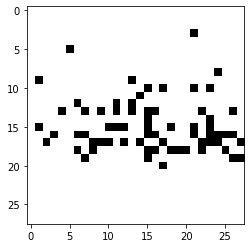

In [17]:
plt.imshow(x, cmap ="Greys")